In [1]:
import Plots
import StatsPlots
using Gen, Statistics, Memoize, Luxor

In [13]:
grid_world = [
     "#"   "#"   "#"   "#"   "V"   "#" ; #1
     "#"   "#"   "#"  "___" "___" "___"; #2
     "#"   "#"  "DN"  "___"  "#"  "___"; #3
     "#"   "#"   "#"  "___"  "#"  "___"; #4
     "#"   "#"   "#"  "___" "___" "___"; #5
     "#"   "#"   "#"  "___"  "#"   "N" ; #6
    "___" "___" "___" "___"  "#"   "#" ; #7
    "DS"   "#"   "#"  "___"  "#"   "#" ; #8
]#    1     2     3     4     5     6

grid_world_default_utilities = Dict(
  "DS" => 1, 
  "DN" => 1, 
  "V" => 3,
  "N" => 2, 
  "___"=> -0.1
)

grid_size = size(grid_world)
n_rows, n_cols = grid_size

actions = [:up,:down,:left,:right];

function transition(state,action)
    if action == :down && state[1] < grid_size[1] && get_tile([state[1]+1,state[2]]) != "#"
        return [state[1]+1,state[2]]
    elseif action == :up && state[1] > 1 && get_tile([state[1]-1,state[2]]) != "#"
        return [state[1]-1, state[2]]
    elseif action == :left && state[2] > 1 && get_tile([state[1],state[2]-1]) != "#"
        return [state[1], state[2]-1]
    elseif action == :right && state[2] < grid_size[2] && get_tile([state[1],state[2]+1]) != "#"
        return [state[1], state[2]+1]
    end
    return [state[1],state[2]]
end;

function get_tile(state)
    return grid_world[state...]
end;

function is_terminal_state(state)
    tile = get_tile(state)
    return tile == "V" || tile == "DN" || tile == "DS" || tile == "N"
end;

In [150]:
CONTROL_FACTOR = 50

function my_sample(probs_dict)
    vals = collect(keys(probs_dict))
    probs = collect(values(probs_dict))
    index = categorical(probs)
    return vals[index]
end

function my_mean(probs_dict)
    vals = collect(keys(probs_dict))
    probs = collect(values(probs_dict))
    return sum(probs.*vals)
end

function fix_distribution(probs_dict)
    probs_sum = sum(collect(values(probs_dict)))
    for key in collect(keys(probs_dict))
        probs_dict[key] /= probs_sum
    end
end

function make_agent(utility_table)
    function utility(state)
        return utility_table[get_tile(state)]
    end
    
    @gen function act(state, time_left)
        action_index = @trace(uniform_discrete(1,length(actions)),:action_index)
        next_action = actions[action_index]
        return expected_utility(state, next_action, time_left)
    end

    @memoize Dict function run_act(state, time_left)
        probs_dict = Dict(:up => 0.,:down => 0.,:left => 0.,:right => 0.)
        for action_index in 1:length(actions)
            trace,weight = generate(act, (state, time_left), choicemap((:action_index,action_index)))
            if time_left > 2
                println("state=$state action=$(actions[action_index]) timeleft=$time_left eu=$(get_retval(trace))")
            end
            probs_dict[actions[action_index]] = exp(weight) + exp(get_retval(trace)*CONTROL_FACTOR)
        end
        fix_distribution(probs_dict)
        return probs_dict
    end

    @gen function reward(state, action, time_left)
        next_state = transition(state, action)
        probs_dict = run_act(next_state, time_left)
        probs = collect(values(probs_dict))
        action_index = @trace(categorical(probs),:action_index)
        next_action = actions[action_index]
        return expected_utility(next_state, next_action, time_left)
    end

    @memoize Dict function run_reward(state, action, time_left)
        probs_dict = Dict()
        weight_sum = 0
        for action_index in 1:length(actions)
            trace,weight = generate(reward, (state, action, time_left), choicemap((:action_index,action_index)))
            eu = get_retval(trace)
            if haskey(probs_dict,eu)
                probs_dict[eu] += exp(weight)
            else
                probs_dict[eu] = exp(weight)
            end
        end
        # println("state=$state, timeleft= $time_left, weight sum = $weight_sum")
        # fix_distribution(probs_dict)
        return probs_dict
    end

    @memoize Dict function expected_utility(state, action, time_left)
        u = utility(state)
        new_time_left = time_left - 1
        if is_terminal_state(state) || new_time_left == 0
            return u
        else
            return u + my_mean(run_reward(state, action, new_time_left))
        end
    end
    return run_act
end

function simulate_agent(utility_table, start_state, total_time, total_steps=total_time)
    trajectory = []
    run_act = make_agent(utility_table)
    next_state = start_state
    while !is_terminal_state(next_state) && total_time > 0 && total_steps > 0
        next_action = my_sample(run_act(next_state, total_time))
        push!(trajectory,[next_state,next_action])
        next_state = transition(next_state, next_action)
        total_time -= 1
        total_steps -=1
    end
    if total_time == 0 || is_terminal_state(next_state)
        push!(trajectory, [next_state,:terminate])
    end  
    return trajectory
end;

In [152]:
trajectory = simulate_agent(grid_world_default_utilities,[7,4],15)

state=[2, 4] action=up timeleft=3 eu=-0.30000000000000004
state=[2, 4] action=down timeleft=3 eu=-0.30000000000000004
state=[2, 4] action=left timeleft=3 eu=-0.30000000000000004
state=[2, 4] action=right timeleft=3 eu=-0.30000000000000004
state=[2, 4] action=up timeleft=4 eu=-0.4
state=[3, 4] action=up timeleft=3 eu=-0.30000000000000004
state=[3, 4] action=down timeleft=3 eu=-0.30000000000000004
state=[3, 4] action=left timeleft=3 eu=0.9
state=[3, 4] action=right timeleft=3 eu=-0.30000000000000004
state=[2, 4] action=down timeleft=4 eu=-0.4
state=[2, 4] action=left timeleft=4 eu=-0.4
state=[2, 5] action=up timeleft=3 eu=2.9
state=[2, 5] action=down timeleft=3 eu=-0.30000000000000004
state=[2, 5] action=left timeleft=3 eu=-0.30000000000000004
state=[2, 5] action=right timeleft=3 eu=-0.30000000000000004
state=[2, 4] action=right timeleft=4 eu=-0.4
state=[2, 4] action=up timeleft=5 eu=-0.5
state=[3, 4] action=up timeleft=4 eu=-0.4
state=[4, 4] action=up timeleft=3 eu=-0.30000000000000004


8-element Vector{Any}:
 Any[[7, 4], :up]
 Any[[6, 4], :right]
 Any[[6, 4], :right]
 Any[[6, 4], :up]
 Any[[5, 4], :right]
 Any[[5, 5], :right]
 Any[[5, 6], :down]
 Any[[6, 6], :terminate]

In [141]:
AMOUNT_POSTERIOR = 1000

target_traj = [[[7,4],:left], [[7,3],:left], [[7,2],:left], [[7,1],:down], [[8,1],:terminate]]
start_state = target_traj[1][1]

options = ["donut", "veg", "noodle"]

function utility_table_prior(option_idx)
    base_table = Dict(
        "DS" => 1, 
        "DN" => 1, 
        "V" => 1,
        "N" => 1, 
        "___"=> -0.04
    )
    option = options[option_idx]
    ret_table = Dict()
    if option == "donut"
        base_table["DS"] = 2
        base_table["DN"] = 2
    elseif option == "veg"
        base_table["V"] = 2
    elseif option == "noodle"
        base_table["N"] = 2
    end
    ret_table["table"] = base_table
    ret_table["favorite"] = option
    return ret_table
end

@gen function posterior(start_state)
    option_idx = @trace(uniform_discrete(1, length(options)), :option_idx)
    utility_table_and_favorite = utility_table_prior(option_idx)
    utility_table = utility_table_and_favorite["table"]
    favorite = utility_table_and_favorite["favorite"]
    sim_traj = simulate_agent(utility_table, start_state,15)
    
    # condition
    if sim_traj == target_traj
        @trace(bernoulli(0.99), :equal_traj)
    else
        @trace(bernoulli(0.01), :equal_traj)
    end
    return favorite
end

function run_posterior(start_state)
    favorites = []
    trace, = generate(posterior, (start_state,), choicemap((:equal_traj,true)))
    for i = 1:AMOUNT_POSTERIOR
        trace, = Gen.mh(trace, select(:option_idx))
        push!(favorites, get_retval(trace))
    end
    return favorites
end;

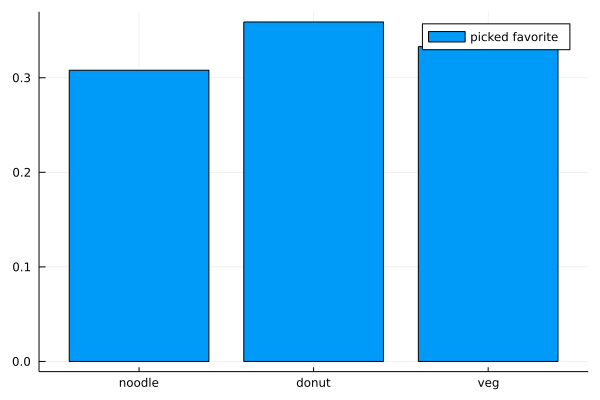

In [143]:
favorites = run_posterior(start_state)
#Eprintln(favorites)
probabilties = Dict([(option,count(favorite-> favorite==option, favorites) / AMOUNT_POSTERIOR) for option in options])
StatsPlots.bar(probabilties, label="picked favorite")